In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import colour
from hydropt.hydropt import Hydropt, ThreeCompModel
from ipywidgets import interact, interactive, FloatLogSlider

In [2]:
plt.style.use('ggplot')

### CIE color matching functions

The python ```colour``` library is used to obtain the colour matching function and conversion of spectral distribution to CIE chromaticity coordinates. For more information on the library see: https://colour.readthedocs.io/

In [3]:
#cmf = pd.read_csv('../colorgen/cie-cmf.csv', index_col=0, delimiter=';')
cmfs = colour.STANDARD_OBSERVERS_CMFS['CIE 1931 2 Degree Standard Observer']

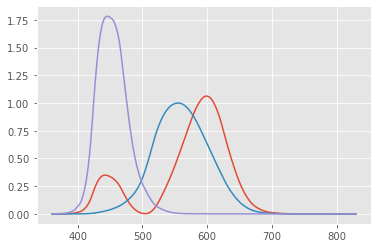

In [4]:
plt.plot(cmfs.domain, cmfs.values)

### Hyperspectral forward model for marine reflectance
We use HYDROPT as our forward model to simulate reflectances between 400 and 710 nm at 5 nm resolution. A 3-component SIOP model is specified for the forward simulations that include CDOM, NAP and one phytoplankton group:

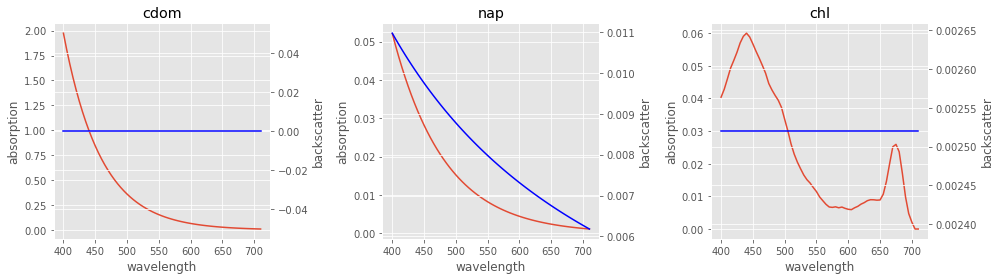

In [5]:
iop_model = ThreeCompModel()
#plot SIOPs for 3 components
iop_model.plot(cdom=1, nap=1, chl=1)

In [6]:
# initialize hydropt instance
hydropt = Hydropt(iop_model)
# get wavebands
wl = iop_model._wavebands

### Deriving XYZ tristimulus values
Below we use the ```colour.sd_to_XYZ``` function from the python ```colour``` library to convert the spectral distribution to XYZ coordinates.

In [7]:
def rrs_to_xyz(wavelength, rrs):
    '''
    rrs_to_xyz converts remote sensing reflectance to
    normalized XYZ tristimilus values
    '''
    # init SpectralDistr. instance
    sd = colour.SpectralDistribution(data=rrs, domain=wavelength)
    # convert Rrs to XYZ
    tristimulus = colour.sd_to_XYZ(sd, cmfs)
    # normalize tristimulus values
    tristimulus_norm = tristimulus/tristimulus.sum()
    
    return tristimulus_norm

### Chromaticity plot
Here we visualize the normalized XY tristimulus values as a function of CDOM, NAP and chlorophyll.

In [8]:
def set_style(ax):
    color = 'white'
    lines = [child for child in ax.get_children() if isinstance(child, matplotlib.lines.Line2D)]
    text =  [child for child in ax.get_children() if isinstance(child, matplotlib.text.Text)]
    [i.set_color(color) for i in lines]
    [i.set_color(color) for i in text[0:14]]
    
    return ax

In [9]:
sliders = {
    'cdom': FloatLogSlider(value=-3, base=10, min=-3, max=0, description='$a_{cdom}(440)$'),
    'nap': FloatLogSlider(value=-2, base=10, min=-2, max=2, description='SPM ($gm^{-3}$)'),
    'chl': FloatLogSlider(value=-2, base=10, min=-2, max=1.5, description='Chl ($mgm^{-3}$)')
}

In [10]:
@interact(cdom=sliders['cdom'] , nap=sliders['nap'], chl=sliders['chl'])
def plot_chromaticity(cdom, nap, chl):
    # plot chromaticity diagram
    f, ax1 = colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False,
                                                              bounding_box=(-.1,.8,-.1,.96))
    #ax2 = f.add_subplot(122)
    f.set_size_inches(16,8)
    ax1.set_facecolor('black')
    ax1.grid(linestyle='--', alpha=.5)
    set_style(ax1)
    # calcute rrs
    rrs = hydropt.forward(cdom=cdom, nap=nap, chl=chl)
    # transform rrs to norm. XY coordinates
    xyz = rrs_to_xyz(iop_model._wavebands, rrs)
    x, y = xyz[:-1]
    # plot xy coordinates    
    ax1.scatter(x, y, s=80, c='white', edgecolor='black', alpha=.9)
    #ax2.plot(wl, rrs)
    f.tight_layout(pad=1)

interactive(children=(FloatLogSlider(value=0.001, description='$a_{cdom}(440)$', max=0.0, min=-3.0), FloatLogS…

### Tristimulus data
Short example of how to get tristimulus values as a function of CDOM, NAP and chlorophyll. Lets assume we fix CDOM at .001 $m^{-1}$ and NAP at 0.01 $g\ m^{-3}$. Now we vary the chlorophyll concentration between 0.01 and 10 $mg\ m^{-3}$. We use our HYDROPT forward model to calculate $R_{rs}$ and subsequentely convert the reflectance signal to normalized XYZ coordinates. 

In [11]:
# set chlorophyll range in log space
chl_range = np.logspace(-2,1,10)
xyz_list = [rrs_to_xyz(wl, hydropt.forward(cdom=.001, nap=.01, chl=i)) for i in chl_range]

In [12]:
xyz_list

[array([ 0.16519676,  0.10555159,  0.72925165]),
 array([ 0.16582339,  0.1096768 ,  0.72449981]),
 array([ 0.16794157,  0.12240701,  0.70965142]),
 array([ 0.17250526,  0.14493399,  0.68256074]),
 array([ 0.18087366,  0.1784006 ,  0.64072574]),
 array([ 0.19461197,  0.22259512,  0.58279291]),
 array([ 0.21490204,  0.27445437,  0.51064359]),
 array([ 0.24176731,  0.32782594,  0.43040675]),
 array([ 0.27371655,  0.37548659,  0.35079686]),
 array([ 0.30820312,  0.41217391,  0.27962296])]

### Hue angle
Now convert normalized xyz tristimilus values to hue angle. The function is defined below:

In [35]:
def xyz_to_hue(xyz, deg=True):
    '''convert xyz tristimulus values to hue angle - Hans et al. 2015
    
    xyz - a 1x2 or 1x3 array with normalized xy or xyz tristimulus values resp.
    deg - bool indicating whether to convert to degrees (instead of rad)
    '''
    #white point
    wp = 1/3
    x, y = xyz[0:2]
    hue = np.arctan2((y-wp), (x-wp)) % (2*np.pi)
    
    return np.rad2deg(hue) if deg else hue

And lets see if ```x=1/3``` and ```y=0.4``` converts to 90 deg. I set ```x=1/2.9999``` since we can't divide by zero.

In [14]:
xyz_to_hue([1/2.9999, .4])

89.990450385182399

Now convert the xyz values in ```xyz_list``` to hue angle (in degrees). To keep values in radians set ```deg=False```

In [15]:
[xyz_to_hue(i, deg=True) for i in xyz_list]

[53.56719600006361,
 53.168233801420506,
 51.899260657300594,
 49.514100462329097,
 45.46095112452079,
 38.599596355162547,
 26.434596905427085,
 3.442005866382214,
 -35.262995962739041,
 -72.320466941446995]

## IOCCG dataset
Read IOCCG $R_{rs}$ spectra into notebook:

In [16]:
ioccg_rrs = pd.read_csv('../colorgen/ioccg_rrs.csv')

In [17]:
ioccg_rrs.head()

400       410       420       430       440       450       460  \
0  0.015763  0.016610  0.015826  0.014521  0.012722  0.010585  0.010058   
1  0.009568  0.010074  0.009841  0.009403  0.008572  0.007548  0.007369   
2  0.011929  0.012356  0.011951  0.011276  0.010238  0.008919  0.008638   
3  0.012547  0.013503  0.013562  0.013268  0.012384  0.011066  0.011003   
4  0.013225  0.013914  0.013326  0.012498  0.011016  0.009325  0.008960   

        470       480       490  ...       710       720       730       740  \
0  0.009532  0.008405  0.007278  ...  0.000068  0.000043  0.000029  0.000021   
1  0.007162  0.006512  0.005724  ...  0.000053  0.000033  0.000022  0.000017   
2  0.008249  0.007372  0.006502  ...  0.000064  0.000040  0.000027  0.000020   
3  0.010787  0.009799  0.008741  ...  0.000086  0.000054  0.000036  0.000027   
4  0.008507  0.007580  0.006548  ...  0.000057  0.000036  0.000024  0.000018   

        750       760       770       780       790       800  
0  0.000019  0.000018  0.000018  0.000018  0.000019  0.000020  
1  0.000015  0.000014  0.000014  0.000014  0.000015  0.000015  
2  0.000018  0.000017  0.000017  0.000017  0.000018  0.000019  
3  0.000024  0.000023  0.000023  0.000023  0.000025  0.000025  
4  0.000016  0.000015  0.000015  0.000015  0.000016  0.000016  

[5 rows x 41 columns]

In [36]:
# get wavebands in ioccg dataset
wavebands = ioccg_rrs.columns.values

Calculate hue angle from all spectra in the IOCCG dataset:

In [37]:
ioccg_hue = ioccg_rrs
ioccg_hue['hue'] = [xyz_to_hue(rrs_to_xyz(wavebands, rrs)) for (_, rrs) in ioccg_rrs.iterrows()]

In [39]:
# save dataset to csv
ioccg_hue.to_csv('../colorgen/ioccg_hue.csv')